# 👖 变分自编码器（Variational Autoencoders）——Fashion-MNIST

本 notebook 演示如何在 Fashion-MNIST 数据集上训练 VAE

本代码改编自 Keras 官网由 [VAE tutorial](https://keras.io/examples/generative/vae/) 编写的优秀VAE 教程

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 0. 参数设置 <a name="parameters"></a>

In [5]:
IMAGE_SIZE = 32  # 输入图像大小
BATCH_SIZE = 100  # 批大小
EMBEDDING_DIM = 2  # 潜空间维度
EPOCHS = 5  # 训练轮数
BETA = 500  # VAE 损失系数

## 1. 数据准备 <a name="prepare"></a>

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,255] -> [0,1]
    transforms.Pad(2)       # 28x28 -> 32x32
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100.0%


## 2. 构建变分自编码器（VAE） <a name="build"></a>

In [7]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        epsilon = torch.randn_like(z_mean).to(DEVICE)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon


In [8]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(128*4*4, embedding_dim)
        self.fc_log_var = nn.Linear(128*4*4, embedding_dim)
        self.sampling = Sampling()
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x_flat = self.flatten(x)
        z_mean = self.fc_mean(x_flat)
        z_log_var = self.fc_log_var(x_flat)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

In [9]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, 128*4*4)
        self.deconv1 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv_out = nn.Conv2d(32, 1, 3, stride=1, padding=1)
    
    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 128, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.conv_out(x))
        return x

In [10]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def loss_function(self, x, recon_x, z_mean, z_log_var):
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean') * BETA
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp()) / x.size(0)
        return recon_loss + kl_loss, recon_loss, kl_loss

In [11]:
encoder = Encoder(EMBEDDING_DIM).to(DEVICE)
decoder = Decoder(EMBEDDING_DIM).to(DEVICE)
vae = VAE(encoder, decoder).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)

## 3. 训练 VAE <a name="train"></a>

In [12]:
for epoch in range(EPOCHS):
    vae.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        optimizer.zero_grad()
        z_mean, z_log_var, recon = vae(imgs)
        loss, _, _ = vae.loss_function(imgs, recon, z_mean, z_log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 156.2591
Epoch 2/5, Loss: 135.1583
Epoch 3/5, Loss: 133.7252
Epoch 4/5, Loss: 132.8164
Epoch 5/5, Loss: 132.2884


## 3. 潜空间可视化 & 生成 <a name="reconstruct"></a>

In [13]:
vae.eval()
example_images = torch.tensor(test_dataset.data[:5000].unsqueeze(1).float()/255.).to(DEVICE)
example_labels = test_dataset.targets[:5000].numpy()

C:\Users\zhao\AppData\Local\Temp\ipykernel_23392\605944599.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  example_images = torch.tensor(test_dataset.data[:5000].unsqueeze(1).float()/255.).to(DEVICE)


## 4. Embed using the encoder <a name="encode"></a>

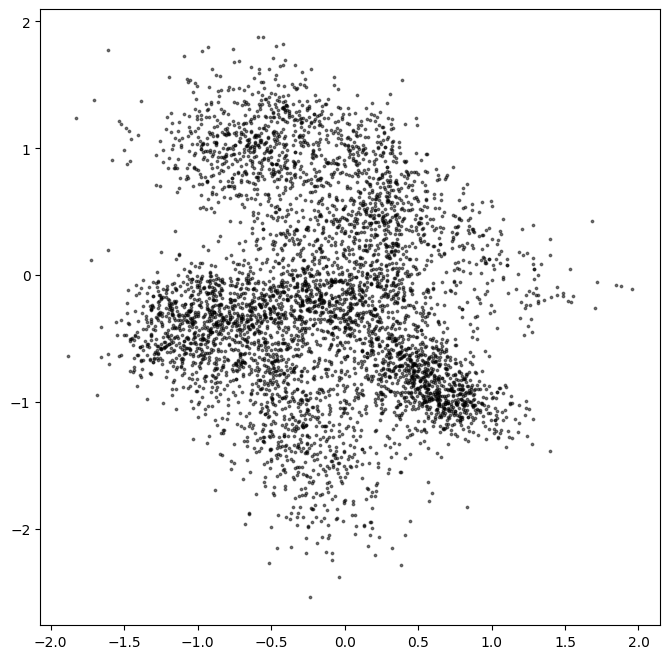

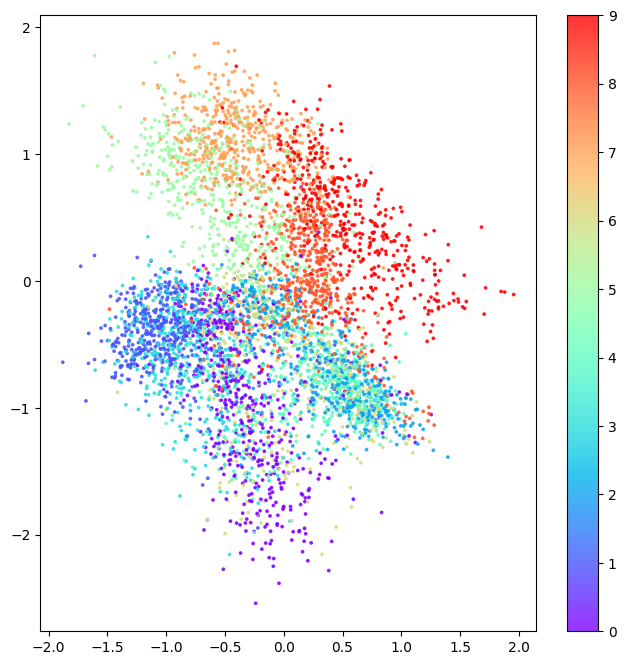

In [14]:
with torch.no_grad():
    z_mean, z_log_var, z = vae.encoder(example_images)
    z = z.cpu().numpy()

# 原始 embeddings
plt.figure(figsize=(8,8))
plt.scatter(z[:,0], z[:,1], c="black", alpha=0.5, s=3)
plt.show()

# 按标签染色
plt.figure(figsize=(8,8))
plt.scatter(z[:,0], z[:,1], c=example_labels, cmap="rainbow", alpha=0.8, s=3)
plt.colorbar()
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [15]:
grid_width, grid_height = 6, 3
z_sample = np.random.normal(size=(grid_width*grid_height, EMBEDDING_DIM))
z_sample_tensor = torch.tensor(z_sample, dtype=torch.float32).to(DEVICE)

with torch.no_grad():
    reconstructions = vae.decoder(z_sample_tensor).cpu().numpy()

## 6. Explore the latent space <a name="explore"></a>

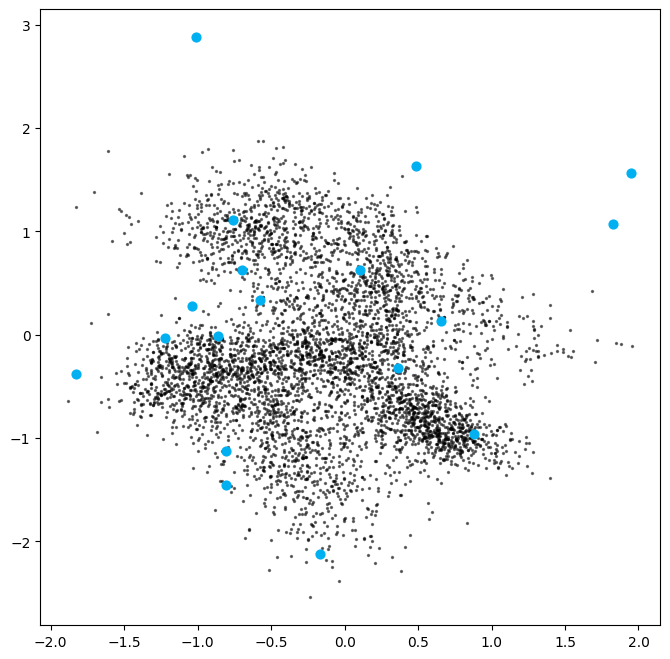

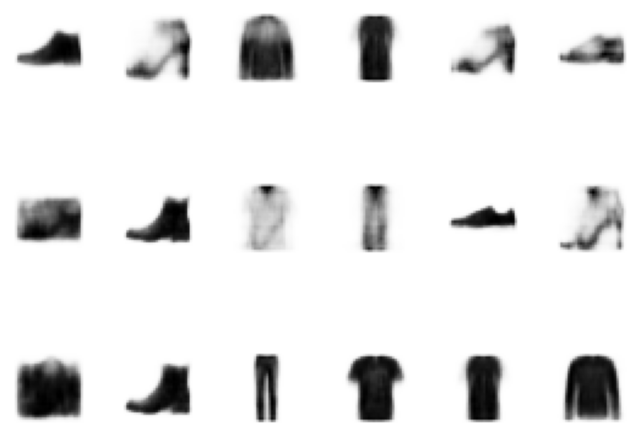

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(z[:,0], z[:,1], c="black", alpha=0.5, s=2)
plt.scatter(z_sample[:,0], z_sample[:,1], c="#00B0F0", alpha=1, s=40)
plt.show()

fig = plt.figure(figsize=(8, grid_height*2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width*grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i+1)
    ax.axis("off")
    ax.imshow(reconstructions[i,0], cmap="Greys")

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |